In [1]:
import numpy as np
from scipy import optimize

import sympy as sp
import matplotlib.pyplot as plt
%matplotlib notebook
import time 
import timeit

In [17]:
class One_leg_controller():
    
    def __init__(self,N,dt,Niter):
        self.N = N
        self.dt = dt
        self.Niter =Niter
    
    d,l1,l2 = 0.0838,0.2,0.22
    d1,d21,d22,d3 = 0.0,d - 0.022327,0.027326,0.13197
    mass = np.array([0.696, 1.013, 0.172],dtype = float)
    gravity = np.array([0,0,9.8],dtype = float).T
    
    def J(self,atp):
        Matrix = np.array
        sin = np.sin
        cos = np.cos

        d,l1,l2 = self.d,self.l1,self.l2
        d1,d21,d22,d3 = self.d1, self.d21, self.d22, self.d3
        
        alpha ,theta,phi = atp

        res =[Matrix([
         [-d1*sin(alpha), 0, 0],
         [                0, 0, 0],
         [-d1*cos(alpha), 0, 0]]),
         Matrix([
         [-d21*sin(alpha) - d22*cos(alpha)*cos(theta), d22*sin(alpha)*sin(theta), 0],
         [                                                   0,              -d22*cos(theta), 0],
         [-d21*cos(alpha) + d22*sin(alpha)*cos(theta), d22*sin(theta)*cos(alpha), 0]]),
         Matrix([
         [-d*sin(alpha) - d3*cos(phi + theta)*cos(alpha) - l1*cos(alpha)*cos(theta), d3*sin(phi + theta)*sin(alpha) + l1*sin(alpha)*sin(theta), d3*sin(phi + theta)*sin(alpha)],
         [                                                                                          0,                            -d3*cos(phi + theta) - l1*cos(theta),              -d3*cos(phi + theta)],
         [-d*cos(alpha) + d3*sin(alpha)*cos(phi + theta) + l1*sin(alpha)*cos(theta), d3*sin(phi + theta)*cos(alpha) + l1*sin(theta)*cos(alpha), d3*sin(phi + theta)*cos(alpha)]])]
        return res

    def dJ(self,atp,datp):

        Matrix = np.array
        sin = np.sin
        cos = np.cos

        #d,l1,l2 = 0.0838,0.2,0.22
        #d1,d21,d22,d3 = 0.0,d - 0.022327,0.027326,0.13197
        d,l1,l2 = self.d,self.l1,self.l2
        d1,d21,d22,d3 = self.d1, self.d21, self.d22, self.d3
        
        alpha ,theta,phi = atp
        dalpha, dtheta, dphi = datp

        res = [Matrix([
         [-d1*cos(alpha)*dalpha, 0, 0],
         [                                        0, 0, 0],
         [ d1*sin(alpha)*dalpha, 0, 0]]),
         Matrix([
         [-d21*cos(alpha)*dalpha + d22*sin(alpha)*cos(theta)*dalpha + d22*sin(theta)*cos(alpha)*dtheta,  d22*sin(alpha)*cos(theta)*dtheta + d22*sin(theta)*cos(alpha)*dalpha, 0],
         [                                                                                                                                                             0,                                                                          d22*sin(theta)*dtheta, 0],
         [ d21*sin(alpha)*dalpha - d22*sin(alpha)*sin(theta)*dtheta + d22*cos(alpha)*cos(theta)*dalpha, -d22*sin(alpha)*sin(theta)*dalpha + d22*cos(alpha)*cos(theta)*dtheta, 0]]),
         Matrix([
         [-d*cos(alpha)*dalpha + d3*(dphi + dtheta)*sin(phi + theta)*cos(alpha) + d3*sin(alpha)*cos(phi + theta)*dalpha + l1*sin(alpha)*cos(theta)*dalpha + l1*sin(theta)*cos(alpha)*dtheta, d3*(dphi + dtheta)*sin(alpha)*cos(phi + theta) + d3*sin(phi + theta)*cos(alpha)*dalpha + l1*sin(alpha)*cos(theta)*dtheta + l1*sin(theta)*cos(alpha)*dalpha, d3*(dphi + dtheta)*sin(alpha)*cos(phi + theta) + d3*sin(phi + theta)*cos(alpha)*dalpha],
         [                                                                                                                                                                                                                                                                                                                       0,                                                                                                                                                        d3*(dphi + dtheta)*sin(phi + theta) + l1*sin(theta)*dtheta,                                                                                 d3*(dphi + dtheta)*sin(phi + theta)],
         [ d*sin(alpha)*dalpha - d3*(dphi + dtheta)*sin(phi + theta)*sin(alpha) + d3*cos(phi + theta)*cos(alpha)*dalpha - l1*sin(alpha)*sin(theta)*dtheta + l1*cos(alpha)*cos(theta)*dalpha, d3*(dphi + dtheta)*cos(phi + theta)*cos(alpha) - d3*sin(phi + theta)*sin(alpha)*dalpha - l1*sin(alpha)*sin(theta)*dalpha + l1*cos(alpha)*cos(theta)*dtheta, d3*(dphi + dtheta)*cos(phi + theta)*cos(alpha) - d3*sin(phi + theta)*sin(alpha)*dalpha]])]
        return res
    
    def fun(self,atp,datp,tau):
        mass = self.mass
        gravity = self.gravity
        
        J_current = self.J(atp)
        dJ_current = self.dJ(atp,datp)

        A = np.zeros((3,3))
        for i in range(3):
            A += mass[i] * J_current[i].T @ J_current[i]

        B = np.zeros((3,3))
        for i in range(3):
            B += mass[i] * J_current[i].T @ dJ_current[i]

        C = np.zeros((3,3))
        for i in range(3):
            C += mass[i] * J_current[i].T

        rhs = B @ datp + C @ gravity - tau
        ddatp = np.linalg.solve(-A, rhs)
        return ddatp
    
    def nextState(self,x0,dx0,tau,dt,iterations = 2):
        y0 = np.array([x0,dx0],dtype =float)
        y_next = y0

        for i in range(iterations):
            y0 = y_next
            rhs = np.array([y0[1],self.fun(y0[0],y0[1],tau)],dtype =float)
            y_next = y0 + dt * rhs
            if sum(abs(y_next[0,:]) > np.ones(3) * 2*np.pi) > 0: # это надо проверить
                print("пахнет жареным, угол провернулся")
                print(y_next)
                print("tau ",tau)
                print("init ",x0,dx0)
        return y_next
    
    def costFun(self,y_predict,tau):
        y0 = self.x_goal
        dy = y0 - y_predict
        A = np.diag([10,1]) # first corresponds to angles, second to d/dt angels
        B = np.array([0],dtype =float) # weight for energy consumption
        cost = np.trace(dy @ dy.T @ A) + tau.T @ tau * B
        
        #print("!!!!!!!!!!!!!!")
        #print("y_pred ",y_predict)
        #print("y_0 - y_pred",dy)
        #print(np.trace(dy @ dy.T @ A))
        #print(dy @ dy.T @ A)
        return cost
    
    def setGoal(self,new_goal):
        self.x_goal = new_goal
    
    sqkls = 0 # удалить потом
    
    def NstepCost(self,init_state,actions):
        self.sqkls += 1
        
        x0 = init_state
        tau = actions[0:3]
        
        J_cost = self.costFun(x0,tau)
        #print("next x : ", x0)
        #print("tau : ", tau)
        for i in range(1,self.N):
            xk = self.nextState(x0[0,:], x0[1,:],tau,self.dt,self.Niter) # ТОЧНОСТЬ ТУТ!!!!!!!!!!!!!!!!!!!!!!!!!          
            tau = actions[i*3:(i+1)*3]
            x0 = xk
            J_cost += self.costFun(x0,tau)
            #print("next x : ", x0)
            #print("tau : ", tau)
            
        return J_cost
            
    
    def get_control_seq(self, init_state):
        
        J_cost = lambda act: self.NstepCost(init_state, act)
        atpLim_min = np.array([-1, -1, -0.5] * self.N)
        atpLim_max = np.array([1, 1, 0.5] * self.N)
        
        bnds = optimize.Bounds(atpLim_min, atpLim_max)
        tau_seq0 = (atpLim_max + atpLim_min)/2
        
        res = optimize.minimize(J_cost, tau_seq0, method='L-BFGS-B', bounds=bnds,options = {"disp":True}) #,"maxfun":200
        action_sqn = res.x
        return action_sqn


In [19]:
N = 4
dt =0.001
Niter = 250
leg_controller = One_leg_controller(N,dt,Niter)

init_state = np.array([[0,0,0],[0,0,0]],dtype = float)

x_goal = np.array([[0,0,0],[0,0,0]],dtype = float)

leg_controller.setGoal(x_goal)

leg_controller.sqkls = 0

t0 = time.time()
actions = leg_controller.get_control_seq(init_state)
t1 = time.time()

print(actions)
print("время вычислений ",t1-t0)
print("циклов метода ",leg_controller.sqkls) 


#%timeit leg_controller.dJ([1,2,3],[4,5,6])
#leg_controller.dJ([1,2,3],[4,5,6])
#leg_controller.J([1,2,3])

x0_var = np.array([[1,2,3],
                   [4,5,6]],dtype =float)
tau_var = np.array([5,6,7],dtype =float)
%timeit leg_controller.fun(x0_var[0,:],x0_var[1,:],tau_var)

пахнет жареным, угол провернулся
[[  0.24777167  -0.18061162   6.34711275]
 [  0.14688112 -27.12082401  71.93902317]]
tau  [-0.57462067  0.04530794 -0.12027087]
init  [0.52828513 0.27602991 3.50026216] [-1.33991964 11.57361831 15.17841704]
пахнет жареным, угол провернулся
[[  0.24791856  -0.20773245   6.41905177]
 [  0.40892537 -25.60058613  67.99723131]]
tau  [-0.57462067  0.04530794 -0.12027087]
init  [0.52828513 0.27602991 3.50026216] [-1.33991964 11.57361831 15.17841704]
пахнет жареным, угол провернулся
[[  0.24832748  -0.23333303   6.48704901]
 [  0.60212684 -23.32084468  62.11609733]]
tau  [-0.57462067  0.04530794 -0.12027087]
init  [0.52828513 0.27602991 3.50026216] [-1.33991964 11.57361831 15.17841704]
пахнет жареным, угол провернулся
[[  0.24892961  -0.25665388   6.5491651 ]
 [  0.72631523 -20.93669242  55.98640181]]
tau  [-0.57462067  0.04530794 -0.12027087]
init  [0.52828513 0.27602991 3.50026216] [-1.33991964 11.57361831 15.17841704]
пахнет жареным, угол провернулся
[[  0.2

[-7.48618788e-01 -1.18842132e-04  1.06342326e-02 -7.50200304e-01
 -5.04537357e-03  1.12047812e-02 -7.48070192e-01  7.29881060e-03
  3.21180369e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00]
время вычислений  262.4920012950897
циклов метода  1911
162 µs ± 3.67 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


actions  [-7.94451862e-01 -9.80042864e-05 -2.91831908e-05 -7.84579977e-01
 -1.20732723e-04  2.51059720e-05 -7.82133044e-01 -2.77052398e-05
 -1.81068276e-04  0.00000000e+00  0.00000000e+00  0.00000000e+00]
[array([0., 0., 0.]), array([-3.29327385e-04, -5.96527665e-06,  1.31403947e-05]), array([-1.27209189e-03, -6.00321508e-05,  1.46481960e-04]), array([-2.71358844e-03, -2.79934229e-05,  5.13241482e-05])]


<IPython.core.display.Javascript object>


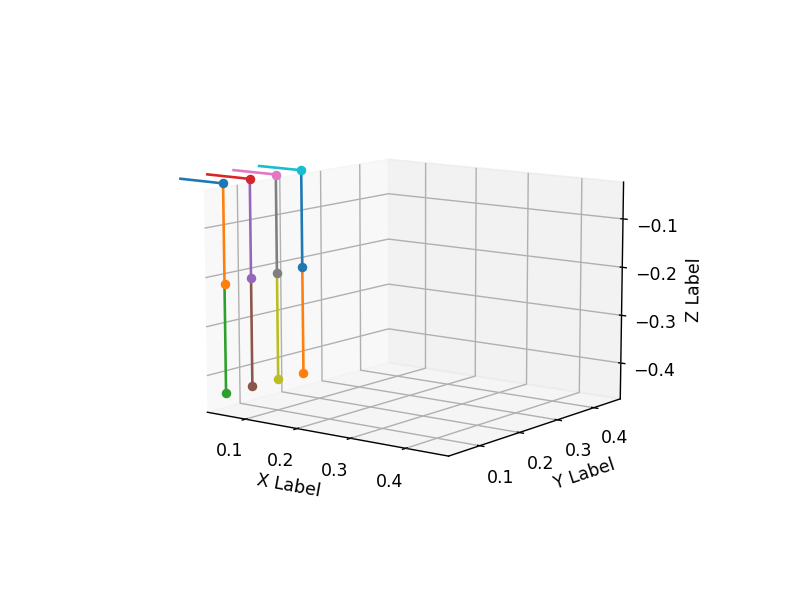

C:\Users\Slava\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:2007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape
C:\Users\Slava\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\stride_tricks.py:341: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(array, copy=False, subok=subok)
C:\Users\Slava\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (

In [9]:
x0 = init_state

#mpc_actions = actions
#actions = np.array([-1,0,0]*N)

tau = actions[0:3]

story = [[0,0,0]]*N
story[0] = x0[0,:]

for i in range(1,N):
    xk = leg_controller.nextState(x0[0,:], x0[1,:],tau,0.001,20)            
    tau = actions[i*3:(i+1)*3]
    x0 = xk
    story[i] = x0[0,:]

print("actions ",actions)    
ppplot(story)

In [7]:

leg_controller = One_leg_controller(N)
leg_controller.setGoal(x_goal)

print("COST:",leg_controller.NstepCost(init_state,actions))
print("my")
print("COST:",leg_controller.NstepCost(init_state,np.array([-4,0,0]*N)))
#leg_controller.nextState(init_state[0,:],init_state[1,:],[-0.9,0,0], 0.0001,50)
actions

COST: [3.58696673]
my
COST: [95.93090156]


array([-7.94451862e-01, -9.80042864e-05, -2.91831908e-05, -7.84579977e-01,
       -1.20732723e-04,  2.51059720e-05, -7.82133044e-01, -2.77052398e-05,
       -1.81068276e-04,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [8]:
def ppplot(my_angels):
    print(my_angels)
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    
    ax.set_xlim3d(0, 1/2)
    ax.set_ylim3d(0, 1/2)
    ax.set_zlim3d(-1/2, 0)
    
    dy = 0.06
    
    for j in range(len(my_angels)):
        a,t,p =my_angels[j]
        x0,y0,z0 = 0,0,0
        for i in range(3):
            x,y,z = plt_points[i](a,t,p) 
            ax.scatter(x,y + dy*j,z)
            ax.plot([x0,x],[y0+ dy*j,y+ dy*j],[z0,z])
            x0,y0,z0 = x[0],y[0],z[0]

In [ ]:
ppplot(story)

In [7]:
t = sp.Symbol('t')
alpha, theta, phi = sp.Function('alpha')(t),sp.Function('theta')(t),sp.Function('phi')(t)
d, l1, l2 = sp.symbols('d l1 l2')
x,y,z = sp.symbols('x y z')
d1,d21,d22,d3 = sp.symbols('d1 d21 d22 d3')
g, m1,m2,m3 = sp.symbols('g m1 m2 m3')

d_real,l1_real,l2_real = 0.0838,0.2,0.22
d1_real,d21_real,d22_real,d3_real = 0.0,d_real - 0.022327,0.027326,0.13197
subs = [(d,d_real),(l1,l1_real),(l2,l2_real),(d1,d1_real),(d21,d21_real),(d22,d22_real),(d3,d3_real)]
angels = [alpha,theta,phi]

plt_points = [[0,0,0]]*3
plt_points[0] = sp.simplify(U(y,alpha) @ T([d,0,0]))[0:3,-1]
plt_points[1] = sp.simplify(U(y,alpha) @ T([d,0,0]) @ U(x,-theta) @ T([0,0,-l1]))[0:3,-1]
plt_points[2] = sp.simplify(U(y,alpha) @ T([d,0,0]) @ U(x,-theta) @ T([0,0,-l1]) @ U(x,-phi) @ T([0,0,-l2]))[0:3,-1]
plt_points = [plt_points[i].subs(subs) for i in range(3)]
plt_points = [sp.lambdify((angels), plt_points[i], modules='numpy') for i in range(3)]

In [6]:
def T(p):
    px,py,pz =p
    return sp.Matrix([[1,0,0,px],
                       [0,1,0,py],
                       [0,0,1,pz],
                       [0,0,0,1]])
def U(ax,angel):
    cos = sp.cos
    sin = sp.sin
    if(ax == sp.Symbol('x')):
        return sp.Matrix([[1,0,0,0]
                      ,[0,cos(angel),-sin(angel),0]
                      ,[0,sin(angel),cos(angel),0]
                      ,[0,0,0,1]])
    if(ax == sp.Symbol('y')):
        return sp.Matrix([[cos(angel),0,sin(angel),0]
                          ,[0,1,0,0]
                          ,[-sin(angel),0,cos(angel),0]
                          ,[0,0,0,1]])
    if(ax == sp.Symbol('z')):
        return sp.Matrix([[cos(angel),-sin(angel),0,0]
                          ,[sin(angel),cos(angel),0,0]
                          ,[0,0,1,0]
                          ,[0,0,0,1]])
    
def SUM(mat):
    res = sp.zeros(mat[0].shape[0],mat[0].shape[1])
    for vec in mat:
        res += vec
    return res

In [13]:
N = 2
dt = 0.001
Niter = 80
leg_controller = One_leg_controller(N,dt,Niter)

init_state = np.array([[0,0,0],[0,0,0]],dtype = float)

x_goal = np.array([[-0.3,0,0],[0,0,0]],dtype = float)

leg_controller.setGoal(x_goal)

count_iter = 10
story = np.zeros((2,3 *count_iter))

x0 = init_state
story[:,0:3] = x0
for i in range(1,count_iter):
    leg_controller.sqkls = 0

    t0 = time.time()
    a = leg_controller.get_control_seq(init_state)
    t1 = time.time()
    
    tau = a[0:3]
    story[:,i*3:(i+1)*3] =  leg_controller.nextState(x0[0,:], x0[1,:],tau,dt,Niter)
    
    x0 = story[:,i*3:(i+1)*3]

    #print(actions)
    print("время вычислений ",t1-t0)
    print("циклов метода ",leg_controller.sqkls)

время вычислений  1.591996192932129
циклов метода  105
время вычислений  1.7199654579162598
циклов метода  105
время вычислений  1.6479625701904297
циклов метода  105
время вычислений  1.6559734344482422
циклов метода  105
время вычислений  1.587975263595581
циклов метода  105
время вычислений  1.6561648845672607
циклов метода  105
время вычислений  1.6319878101348877
циклов метода  105
время вычислений  1.6040005683898926
циклов метода  105
время вычислений  1.6199734210968018
циклов метода  105


[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-4.77369598e-03 -2.64046695e-07  7.51332227e-07]
 [-1.82259687e-02  9.34662135e-08  8.78308854e-09]
 [-3.75706792e-02 -1.50641359e-07  8.99272268e-07]
 [-5.88412346e-02  2.70354164e-07  7.39792356e-08]
 [-7.77443909e-02 -2.92656851e-08  1.06207427e-06]
 [-9.05265209e-02  3.84608797e-07  9.33789331e-08]
 [-9.46775802e-02 -2.71144703e-08  1.13499509e-06]
 [-8.93730741e-02  3.50846008e-07  4.02782591e-09]
 [-7.56167026e-02 -1.62814447e-07  1.09692498e-06]]


<IPython.core.display.Javascript object>


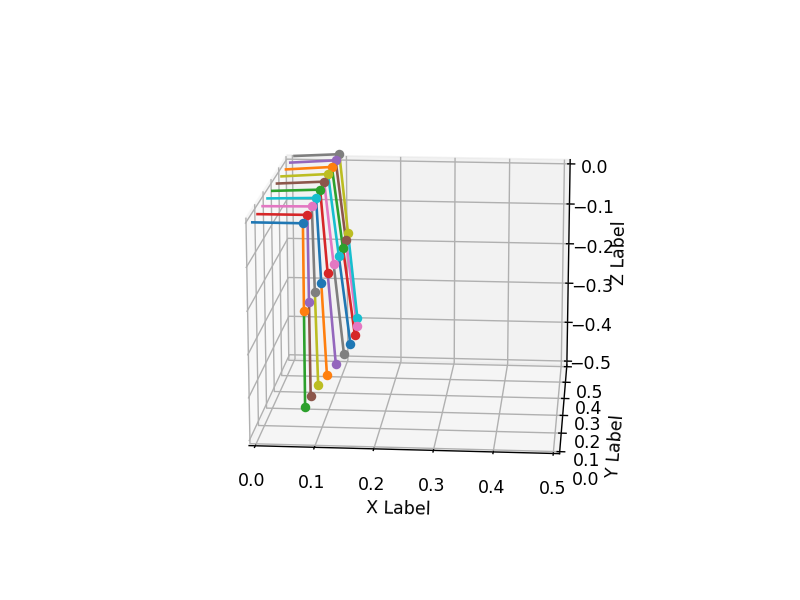

In [14]:
ppplot(story[0,:].reshape(count_iter,3))

In [23]:
story[0,:].reshape(3,3)

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-3.29327385e-04, -5.96527665e-06,  1.31403947e-05],
       [-1.34781960e-03, -2.15586938e-05,  4.63793933e-05]])

In [19]:
b = np.copy(a)
b[0] = 8


array([ 8.00000000e+00, -9.80042864e-05, -2.91831908e-05, -7.84579977e-01,
       -1.20732723e-04,  2.51059720e-05, -7.82133044e-01, -2.77052398e-05,
       -1.81068276e-04,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [ ]:
b2 = np.array([0]*10)
print(b2)
b2[1:3] = np.copy(a[1:3])
print(b2)

In [15]:
size(2)

NameError: name 'size' is not defined

In [ ]:
len(b2)